In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
os.chdir("src")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from anomaly_detection import *
from utils import *
from data_preparation import *
from constants import DATA_PATH, SEP_CSV

import tensorflow as tf
# tf.config.run_functions_eagerly(True)

In [5]:
os.chdir("../")

In [10]:
# Build the detect anomalies_function by taking input variables
def detect_anomalies(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback=20, threshold=0.2):
    # Get the data
    df_prep = get_data()
    timeseries = get_filtered_timeseries(df_prep, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(timeseries.values)

    # Prepare the data for LSTM
    def prepare_data(timeseries, lookback):
        X, y = [], []
        for i in range(len(timeseries) - lookback):
            X.append(timeseries[i:i+lookback])
            y.append(timeseries[i+lookback])
        return np.array(X), np.array(y)

    X, y = prepare_data(normalized_data, lookback)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(lookback, 1)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'], run_eagerly=True)
    model.fit(X_train, y_train, epochs=20, batch_size=32)

    # Predict the anomalies using the trained LSTM model
    predicted_data = model.predict(X)
    anomalies = predicted_data - y > threshold
    
    # f = plot_sample(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)
    # print(f)

    # Optionally, you can plot the detected anomalies and return the anomalies and dates:
    def plot_anomalies(data, anomalies):
        plt.plot(data, label='Data')

        anomaly_indices = np.where(anomalies)[0] + lookback
        anomaly_dates = timeseries.index[anomaly_indices]

        anomalies_dict = {index: date for index, date in zip(anomaly_indices, anomaly_dates)}
        dates_dict = {index: date for index, date in enumerate(timeseries.index)}

        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, data[anomaly_indices], color='r', label='Anomaly')

        predicted_indices = np.arange(lookback, len(data))
        plt.plot(predicted_indices, predicted_data, color='g', label='Predicted')

        plt.legend()
        plt.show()

        # Sort the anomalies_dict by timestamp
        sorted_anomalies_dict = {index: anomalies_dict[index] for index in sorted(anomalies_dict, key=lambda x: anomalies_dict[x])}

        return sorted_anomalies_dict, dates_dict

    # Call the plot_anomalies function and store the returned dictionaries
    anomalies_dict, dates_dict = plot_anomalies(normalized_data, anomalies)

    # Print anomalies and their dates
    print("Anomalies:", len(anomalies_dict))
    print("Dates:", len(dates_dict))
    print("Anomalies:", anomalies_dict)

Epoch 1/20
9/9 [==============================] - 0s 42ms/step - loss: 0.0927 - accuracy: 0.0772
Epoch 2/20
9/9 [==============================] - 0s 39ms/step - loss: 0.0646 - accuracy: 0.0735
Epoch 3/20
9/9 [==============================] - 0s 40ms/step - loss: 0.0605 - accuracy: 0.0772
Epoch 4/20
9/9 [==============================] - 0s 49ms/step - loss: 0.0587 - accuracy: 0.0772
Epoch 5/20
9/9 [==============================] - 0s 40ms/step - loss: 0.0567 - accuracy: 0.0772
Epoch 6/20
9/9 [==============================] - 0s 43ms/step - loss: 0.0553 - accuracy: 0.0772
Epoch 7/20
9/9 [==============================] - 0s 38ms/step - loss: 0.0536 - accuracy: 0.0772
Epoch 8/20
9/9 [==============================] - 0s 39ms/step - loss: 0.0526 - accuracy: 0.0772
Epoch 9/20
9/9 [==============================] - 0s 43ms/step - loss: 0.0516 - accuracy: 0.0772
Epoch 10/20
9/9 [==============================] - 0s 43ms/step - loss: 0.0500 - accuracy: 0.0772
Epoch 11/20
9/9 [============

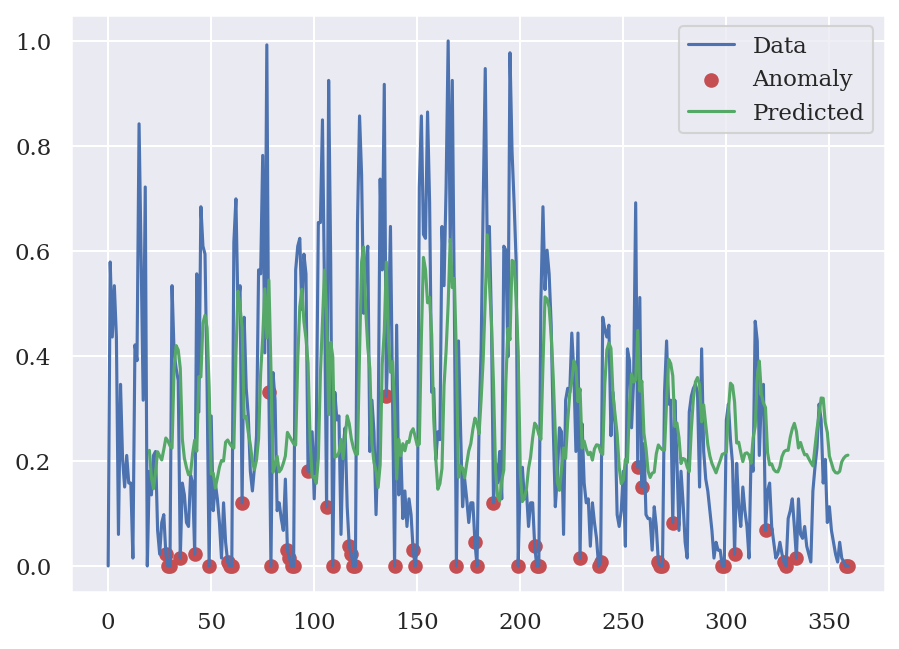

Anomalies: 53
Dates: 360
Anomalies: {30: Timestamp('2004-02-01 00:00:00'), 60: Timestamp('2004-03-01 00:00:00'), 90: Timestamp('2004-04-01 00:00:00'), 120: Timestamp('2004-05-01 00:00:00'), 29: Timestamp('2008-01-01 00:00:00'), 59: Timestamp('2008-02-01 00:00:00'), 89: Timestamp('2008-03-01 00:00:00'), 119: Timestamp('2008-04-01 00:00:00'), 149: Timestamp('2008-05-01 00:00:00'), 179: Timestamp('2008-06-01 00:00:00'), 209: Timestamp('2008-07-01 00:00:00'), 239: Timestamp('2008-08-01 00:00:00'), 269: Timestamp('2008-09-01 00:00:00'), 274: Timestamp('2008-10-01 00:00:00'), 299: Timestamp('2008-10-01 00:00:00'), 304: Timestamp('2008-11-01 00:00:00'), 329: Timestamp('2008-11-01 00:00:00'), 334: Timestamp('2008-12-01 00:00:00'), 359: Timestamp('2008-12-01 00:00:00'), 35: Timestamp('2009-02-01 00:00:00'), 65: Timestamp('2009-03-01 00:00:00'), 49: Timestamp('2010-02-01 00:00:00'), 79: Timestamp('2010-03-01 00:00:00'), 109: Timestamp('2010-04-01 00:00:00'), 139: Timestamp('2010-05-01 00:00:00')

In [11]:
detect_anomalies('Belgien', 'MINI', 'Cabrio', '', lookback=20, threshold=0.2)

Epoch 1/20
1/1 [==============================] - 0s 46ms/step - loss: 0.1052 - accuracy: 0.3636
Epoch 2/20
1/1 [==============================] - 0s 46ms/step - loss: 0.0981 - accuracy: 0.3636
Epoch 3/20
1/1 [==============================] - 0s 38ms/step - loss: 0.0917 - accuracy: 0.3636
Epoch 4/20
1/1 [==============================] - 0s 37ms/step - loss: 0.0863 - accuracy: 0.3636
Epoch 5/20
1/1 [==============================] - 0s 36ms/step - loss: 0.0816 - accuracy: 0.3636
Epoch 6/20
1/1 [==============================] - 0s 34ms/step - loss: 0.0778 - accuracy: 0.3636
Epoch 7/20
1/1 [==============================] - 0s 33ms/step - loss: 0.0749 - accuracy: 0.3636
Epoch 8/20
1/1 [==============================] - 0s 33ms/step - loss: 0.0729 - accuracy: 0.3636
Epoch 9/20
1/1 [==============================] - 0s 35ms/step - loss: 0.0718 - accuracy: 0.3636
Epoch 10/20
1/1 [==============================] - 0s 34ms/step - loss: 0.0717 - accuracy: 0.3636
Epoch 11/20
1/1 [============

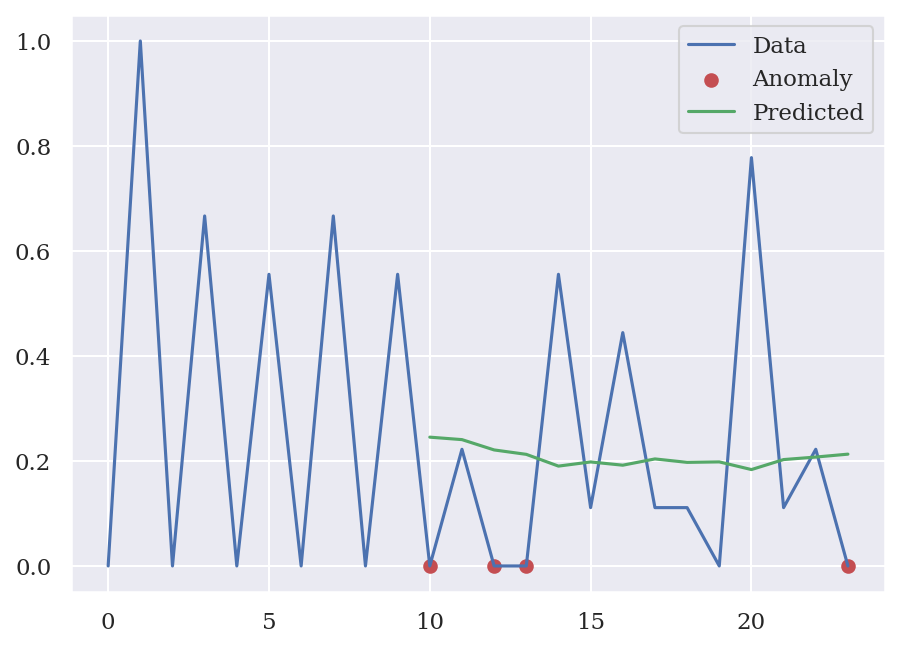

Anomalies: 4
Dates: 24
Anomalies: {10: Timestamp('2004-06-01 00:00:00'), 12: Timestamp('2004-07-01 00:00:00'), 13: Timestamp('2005-07-01 00:00:00'), 23: Timestamp('2005-12-01 00:00:00')}


In [14]:
detect_anomalies('Niederlande', 'PGO', 'Roadster', 'unspec.', lookback=10, threshold=0.2)

Epoch 1/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0833 - accuracy: 0.3137
Epoch 2/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0710 - accuracy: 0.3137
Epoch 3/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0598 - accuracy: 0.3137
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0537 - accuracy: 0.3137
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0522 - accuracy: 0.3137
Epoch 6/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0554 - accuracy: 0.3137
Epoch 7/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0564 - accuracy: 0.3137
Epoch 8/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0546 - accuracy: 0.3137
Epoch 9/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0528 - accuracy: 0.3137
Epoch 10/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0521 - accuracy: 0.3137
Epoch 11/20
2/2 [============

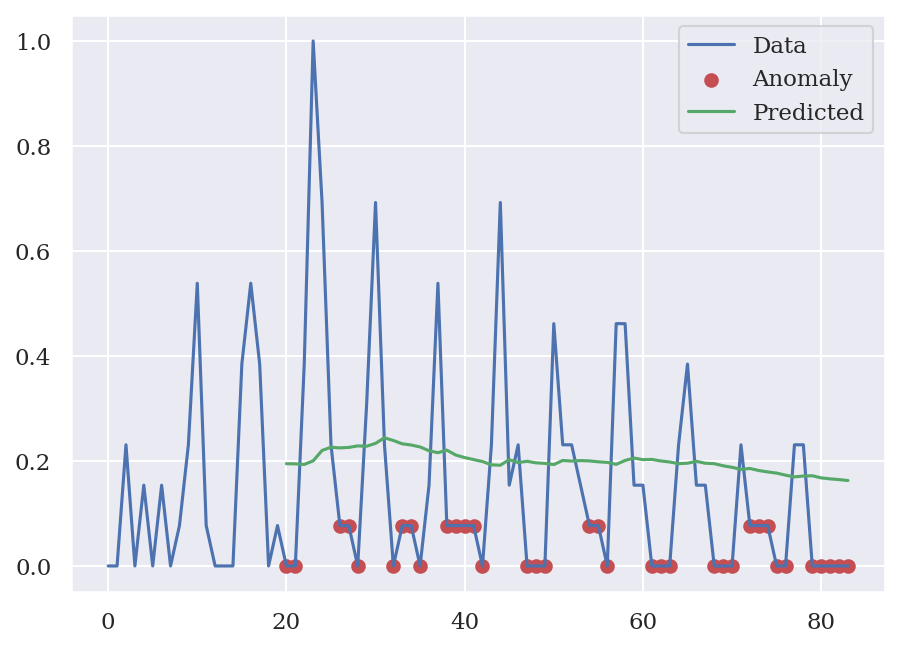

Anomalies: 36
Dates: 84
Anomalies: {21: Timestamp('2013-04-01 00:00:00'), 28: Timestamp('2013-05-01 00:00:00'), 35: Timestamp('2013-06-01 00:00:00'), 42: Timestamp('2013-07-01 00:00:00'), 49: Timestamp('2013-08-01 00:00:00'), 56: Timestamp('2013-09-01 00:00:00'), 63: Timestamp('2013-10-01 00:00:00'), 70: Timestamp('2013-11-01 00:00:00'), 72: Timestamp('2015-11-01 00:00:00'), 79: Timestamp('2015-12-01 00:00:00'), 38: Timestamp('2016-06-01 00:00:00'), 73: Timestamp('2016-11-01 00:00:00'), 80: Timestamp('2016-12-01 00:00:00'), 32: Timestamp('2017-05-01 00:00:00'), 39: Timestamp('2017-06-01 00:00:00'), 74: Timestamp('2017-11-01 00:00:00'), 81: Timestamp('2017-12-01 00:00:00'), 26: Timestamp('2018-04-01 00:00:00'), 33: Timestamp('2018-05-01 00:00:00'), 40: Timestamp('2018-06-01 00:00:00'), 47: Timestamp('2018-07-01 00:00:00'), 54: Timestamp('2018-08-01 00:00:00'), 61: Timestamp('2018-09-01 00:00:00'), 68: Timestamp('2018-10-01 00:00:00'), 75: Timestamp('2018-11-01 00:00:00'), 82: Timestamp(

In [13]:
detect_anomalies('Belgien', 'Alfa Romeo', 'Coupe', '4C', lookback=20, threshold=0.1)

In [15]:
def identify_offer_interruptions_withAll(df, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, interruption_threshold):
    filtered_df = df[(df['c_FEATURE_1'] == c_FEATURE_1) &
                     (df['c_FEATURE_2'] == c_FEATURE_2) &
                     (df['c_FEATURE_3'] == c_FEATURE_3) &
                     (df['c_FEATURE_4'] == c_FEATURE_4)]  # Filter by c_FEATUREs
    offer_interruptions = filtered_df[filtered_df['c_VALUE'] < interruption_threshold]
    offer_interruptions = offer_interruptions.reset_index()
    return offer_interruptions

df = get_data()

In [16]:
offer_interruptions = identify_offer_interruptions_withAll(df, 'Belgien', 'MINI', 'Cabrio', '', interruption_threshold=2)
print("\nOffer Interruptions:")
print(offer_interruptions)


Offer Interruptions:
       c_DATE c_FEATURE_1 c_FEATURE_2 c_FEATURE_3 c_FEATURE_4  c_VALUE
0  2004-01-01     Belgien        MINI      Cabrio                    0
1  2010-01-01     Belgien        MINI      Cabrio                    0
2  2008-01-01     Belgien        MINI      Cabrio                    0
3  2004-02-01     Belgien        MINI      Cabrio                    0
4  2010-02-01     Belgien        MINI      Cabrio                    0
5  2019-02-01     Belgien        MINI      Cabrio                    1
6  2008-02-01     Belgien        MINI      Cabrio                    0
7  2004-03-01     Belgien        MINI      Cabrio                    0
8  2010-03-01     Belgien        MINI      Cabrio                    0
9  2008-03-01     Belgien        MINI      Cabrio                    0
10 2004-04-01     Belgien        MINI      Cabrio                    0
11 2010-04-01     Belgien        MINI      Cabrio                    0
12 2008-04-01     Belgien        MINI      Cabrio      

In [17]:
offer_interruptions = identify_offer_interruptions_withAll(df, 'Niederlande', 'PGO', 'Roadster', 'unspec.', interruption_threshold=1)
print("\nOffer Interruptions:")
print(offer_interruptions)


Offer Interruptions:
      c_DATE  c_FEATURE_1 c_FEATURE_2 c_FEATURE_3 c_FEATURE_4  c_VALUE
0 2004-01-01  Niederlande         PGO    Roadster     unspec.        0
1 2004-02-01  Niederlande         PGO    Roadster     unspec.        0
2 2004-03-01  Niederlande         PGO    Roadster     unspec.        0
3 2004-04-01  Niederlande         PGO    Roadster     unspec.        0
4 2004-05-01  Niederlande         PGO    Roadster     unspec.        0
5 2004-06-01  Niederlande         PGO    Roadster     unspec.        0
6 2004-07-01  Niederlande         PGO    Roadster     unspec.        0
7 2005-07-01  Niederlande         PGO    Roadster     unspec.        0
8 2005-10-01  Niederlande         PGO    Roadster     unspec.        0
9 2005-12-01  Niederlande         PGO    Roadster     unspec.        0


In [18]:
offer_interruptions = identify_offer_interruptions_withAll(df, 'Belgien', 'Alfa Romeo', 'Coupe', '4C', interruption_threshold=1)
print("\nOffer Interruptions:")
print(offer_interruptions)


Offer Interruptions:
       c_DATE c_FEATURE_1 c_FEATURE_2 c_FEATURE_3 c_FEATURE_4  c_VALUE
0  2013-01-01     Belgien  Alfa Romeo       Coupe          4C        0
1  2014-01-01     Belgien  Alfa Romeo       Coupe          4C        0
2  2016-01-01     Belgien  Alfa Romeo       Coupe          4C        0
3  2018-01-01     Belgien  Alfa Romeo       Coupe          4C        0
4  2013-02-01     Belgien  Alfa Romeo       Coupe          4C        0
5  2018-02-01     Belgien  Alfa Romeo       Coupe          4C        0
6  2019-02-01     Belgien  Alfa Romeo       Coupe          4C        0
7  2013-03-01     Belgien  Alfa Romeo       Coupe          4C        0
8  2017-03-01     Belgien  Alfa Romeo       Coupe          4C        0
9  2019-03-01     Belgien  Alfa Romeo       Coupe          4C        0
10 2013-04-01     Belgien  Alfa Romeo       Coupe          4C        0
11 2013-05-01     Belgien  Alfa Romeo       Coupe          4C        0
12 2017-05-01     Belgien  Alfa Romeo       Coupe      

In [19]:
def detect_anomalies2(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback=20, threshold=0.1):
    # Get the data
    df_prep = get_data()
    timeseries = get_filtered_timeseries(df_prep, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(timeseries.values)

    # Prepare the data for LSTM
    def prepare_data(timeseries, lookback):
        X, y = [], []
        for i in range(len(timeseries) - lookback):
            X.append(timeseries[i:i+lookback])
            y.append(timeseries[i+lookback])
        return np.array(X), np.array(y)

    X, y = prepare_data(normalized_data, lookback)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(lookback, 1)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Predict the anomalies using the trained LSTM model
    predicted_data = model.predict(X)
    anomalies = np.abs(predicted_data - y) > threshold

    # Optionally, you can plot the detected anomalies and return the anomalies and dates:
    def plot_anomalies(data, anomalies):
        plt.plot(data, label='Data')

        anomaly_indices = np.where(anomalies)[0] + lookback
        anomaly_dates = timeseries.index[anomaly_indices]

        anomalies_dict = {index: date for index, date in zip(anomaly_indices, anomaly_dates)}
        dates_dict = {index: date for index, date in enumerate(timeseries.index)}

        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, data[anomaly_indices], color='r', label='Anomaly')

        predicted_indices = np.arange(lookback, len(data))
        plt.plot(predicted_indices, predicted_data, color='g', label='Predicted')

        plt.legend()
        plt.show()

        return anomalies_dict, dates_dict

    # Call the plot_anomalies function and store the returned dictionaries
    anomalies_dict, dates_dict = plot_anomalies(normalized_data, anomalies)

    # Print anomalies and their dates
    print("Anomalies:", len(anomalies_dict))
    print("Dates:", len(dates_dict))
    print("Anomalies:", anomalies_dict)


Epoch 1/10
9/9 [==============================] - 0s 44ms/step - loss: 0.7002 - accuracy: 0.0772
Epoch 2/10
9/9 [==============================] - 0s 41ms/step - loss: 0.6212 - accuracy: 0.0588
Epoch 3/10
9/9 [==============================] - 0s 42ms/step - loss: 0.6051 - accuracy: 0.0699
Epoch 4/10
9/9 [==============================] - 0s 46ms/step - loss: 0.6009 - accuracy: 0.0772
Epoch 5/10
9/9 [==============================] - 0s 46ms/step - loss: 0.5987 - accuracy: 0.0772
Epoch 6/10
9/9 [==============================] - 0s 42ms/step - loss: 0.5954 - accuracy: 0.0772
Epoch 7/10
9/9 [==============================] - 0s 40ms/step - loss: 0.5936 - accuracy: 0.0772
Epoch 8/10
9/9 [==============================] - 0s 40ms/step - loss: 0.5917 - accuracy: 0.0772
Epoch 9/10
9/9 [==============================] - 0s 45ms/step - loss: 0.5898 - accuracy: 0.0772
Epoch 10/10
11/11 [==============================] - 0s 17ms/step


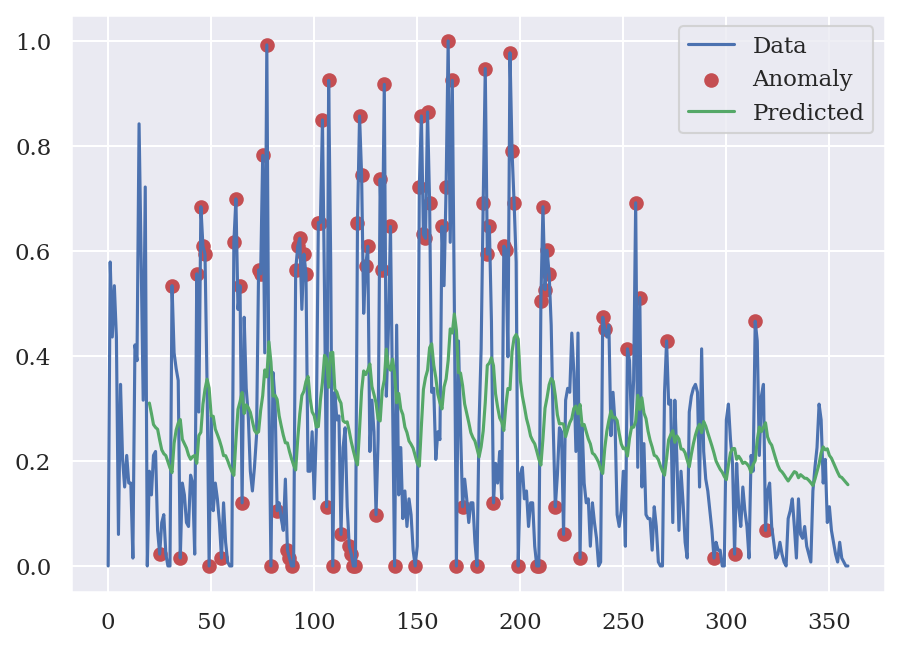

Anomalies: 94
Dates: 360
Anomalies: {25: Timestamp('2016-01-01 00:00:00'), 31: Timestamp('2005-02-01 00:00:00'), 35: Timestamp('2009-02-01 00:00:00'), 43: Timestamp('2017-02-01 00:00:00'), 45: Timestamp('2019-02-01 00:00:00'), 46: Timestamp('2020-02-01 00:00:00'), 47: Timestamp('2021-02-01 00:00:00'), 49: Timestamp('2010-02-01 00:00:00'), 55: Timestamp('2016-02-01 00:00:00'), 61: Timestamp('2005-03-01 00:00:00'), 62: Timestamp('2006-03-01 00:00:00'), 64: Timestamp('2008-03-01 00:00:00'), 65: Timestamp('2009-03-01 00:00:00'), 73: Timestamp('2017-03-01 00:00:00'), 74: Timestamp('2018-03-01 00:00:00'), 75: Timestamp('2019-03-01 00:00:00'), 77: Timestamp('2021-03-01 00:00:00'), 79: Timestamp('2010-03-01 00:00:00'), 82: Timestamp('2013-03-01 00:00:00'), 87: Timestamp('2018-03-01 00:00:00'), 88: Timestamp('2019-03-01 00:00:00'), 89: Timestamp('2008-03-01 00:00:00'), 91: Timestamp('2005-04-01 00:00:00'), 92: Timestamp('2006-04-01 00:00:00'), 93: Timestamp('2007-04-01 00:00:00'), 95: Timestamp

In [20]:
detect_anomalies2('Belgien', 'MINI', 'Cabrio', '', lookback=20, threshold=0.2)

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.6909 - accuracy: 0.3636
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6362 - accuracy: 0.3636
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 0.6017 - accuracy: 0.3636
Epoch 4/10
1/1 [==============================] - 0s 43ms/step - loss: 0.5792 - accuracy: 0.3636
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5649 - accuracy: 0.3636
Epoch 6/10
1/1 [==============================] - 0s 34ms/step - loss: 0.5565 - accuracy: 0.3636
Epoch 7/10
1/1 [==============================] - 0s 34ms/step - loss: 0.5526 - accuracy: 0.3636
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5520 - accuracy: 0.3636
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 0.5535 - accuracy: 0.3636
Epoch 10/10
1/1 [==============================] - 0s 29ms/step


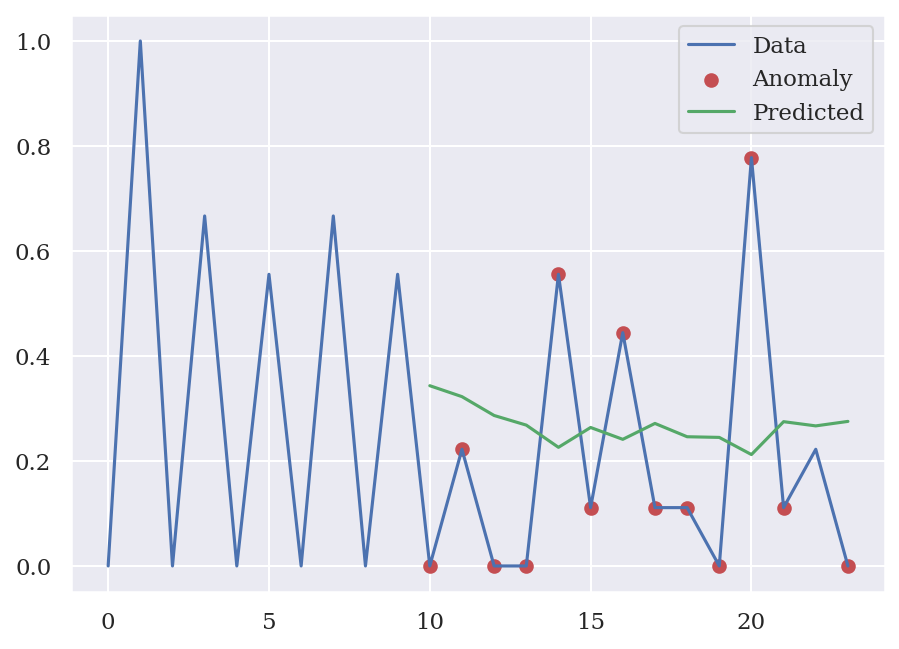

Anomalies: 13
Dates: 24
Anomalies: {10: Timestamp('2004-06-01 00:00:00'), 11: Timestamp('2005-06-01 00:00:00'), 12: Timestamp('2004-07-01 00:00:00'), 13: Timestamp('2005-07-01 00:00:00'), 14: Timestamp('2004-08-01 00:00:00'), 15: Timestamp('2005-08-01 00:00:00'), 16: Timestamp('2004-09-01 00:00:00'), 17: Timestamp('2005-09-01 00:00:00'), 18: Timestamp('2004-10-01 00:00:00'), 19: Timestamp('2005-10-01 00:00:00'), 20: Timestamp('2004-11-01 00:00:00'), 21: Timestamp('2005-11-01 00:00:00'), 23: Timestamp('2005-12-01 00:00:00')}


In [21]:
detect_anomalies2('Niederlande', 'PGO', 'Roadster', 'unspec.', lookback=10, threshold=0.1)

Epoch 1/10
2/2 [==============================] - 0s 56ms/step - loss: 0.6656 - accuracy: 0.3137
Epoch 2/10
2/2 [==============================] - 0s 48ms/step - loss: 0.5602 - accuracy: 0.3137
Epoch 3/10
2/2 [==============================] - 0s 48ms/step - loss: 0.5057 - accuracy: 0.3137
Epoch 4/10
2/2 [==============================] - 0s 50ms/step - loss: 0.4951 - accuracy: 0.3137
Epoch 5/10
2/2 [==============================] - 0s 49ms/step - loss: 0.4858 - accuracy: 0.3137
Epoch 6/10
2/2 [==============================] - 0s 49ms/step - loss: 0.4897 - accuracy: 0.3137
Epoch 7/10
2/2 [==============================] - 0s 54ms/step - loss: 0.4961 - accuracy: 0.3137
Epoch 8/10
2/2 [==============================] - 0s 50ms/step - loss: 0.4989 - accuracy: 0.3137
Epoch 9/10
2/2 [==============================] - 0s 49ms/step - loss: 0.4997 - accuracy: 0.3137
Epoch 10/10
2/2 [==============================] - 0s 21ms/step


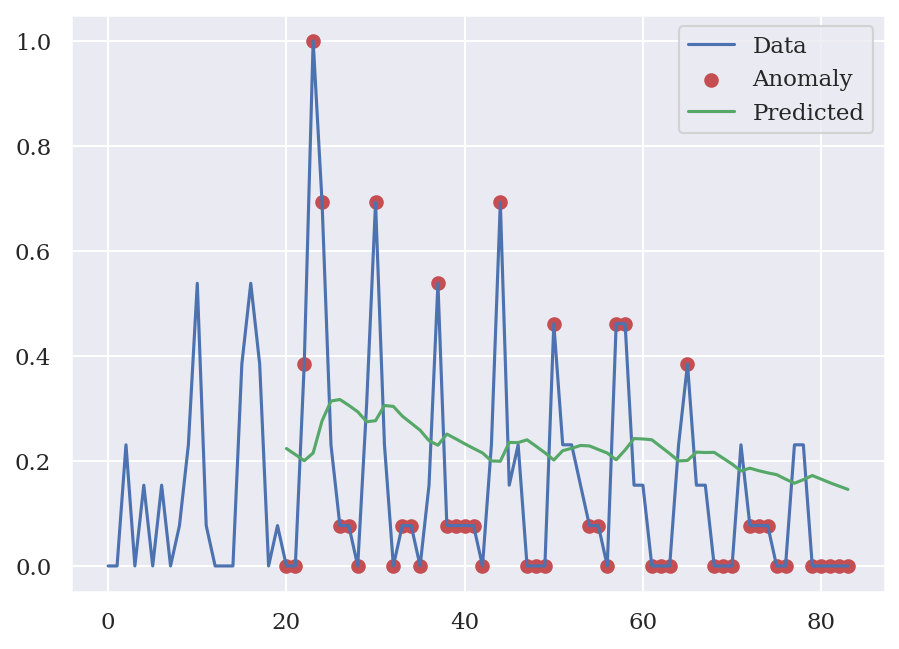

Anomalies: 46
Dates: 84
Anomalies: {20: Timestamp('2019-03-01 00:00:00'), 21: Timestamp('2013-04-01 00:00:00'), 22: Timestamp('2014-04-01 00:00:00'), 23: Timestamp('2015-04-01 00:00:00'), 24: Timestamp('2016-04-01 00:00:00'), 26: Timestamp('2018-04-01 00:00:00'), 27: Timestamp('2019-04-01 00:00:00'), 28: Timestamp('2013-05-01 00:00:00'), 30: Timestamp('2015-05-01 00:00:00'), 32: Timestamp('2017-05-01 00:00:00'), 33: Timestamp('2018-05-01 00:00:00'), 34: Timestamp('2019-05-01 00:00:00'), 35: Timestamp('2013-06-01 00:00:00'), 37: Timestamp('2015-06-01 00:00:00'), 38: Timestamp('2016-06-01 00:00:00'), 39: Timestamp('2017-06-01 00:00:00'), 40: Timestamp('2018-06-01 00:00:00'), 41: Timestamp('2019-06-01 00:00:00'), 42: Timestamp('2013-07-01 00:00:00'), 44: Timestamp('2015-07-01 00:00:00'), 47: Timestamp('2018-07-01 00:00:00'), 48: Timestamp('2019-07-01 00:00:00'), 49: Timestamp('2013-08-01 00:00:00'), 50: Timestamp('2014-08-01 00:00:00'), 54: Timestamp('2018-08-01 00:00:00'), 55: Timestamp(

In [22]:
detect_anomalies2('Belgien', 'Alfa Romeo', 'Coupe', '4C', lookback=20, threshold=0.1)

In [ ]:
def detect_anomalies3(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback=10, threshold=0.1):
    # Get the data
    df_prep = get_data()
    timeseries = get_filtered_timeseries(df_prep, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(timeseries.values)

    # Prepare the data for LSTM
    def prepare_data(timeseries, lookback):
        X, y = [], []
        for i in range(len(timeseries) - lookback):
            X.append(timeseries[i:i+lookback])
            y.append(timeseries[i+lookback])
        return np.array(X), np.array(y)

    X, y = prepare_data(normalized_data, lookback)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    
    # Lists to store loss and accuracy values
    loss_history = []
    accuracy_history = []

    for epoch in range(10):
        history = model.fit(X_train, y_train, epochs=1, batch_size=32)
        loss = history.history['loss'][0]
        loss_history.append(loss)
        accuracy = model.evaluate(X_test, y_test, verbose=0)
        accuracy_history.append(1 - accuracy)

    # Plot the loss function over iterations
    plt.plot(loss_history)
    plt.title('Loss Function Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

    # Plot the accuracy score over iterations
    plt.plot(accuracy_history)
    plt.title('Accuracy Score Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy Score')
    plt.show()

    # Predict the anomalies using the trained LSTM model
    predicted_data = model.predict(X)
    anomalies = predicted_data - y > threshold
    
    f = plot_sample(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)
    print(f)

    # Optionally, you can plot the detected anomalies and return the anomalies and dates:
    def plot_anomalies(data, anomalies):
        plt.plot(data, label='Data')

        anomaly_indices = np.where(anomalies)[0] + lookback
        anomaly_dates = timeseries.index[anomaly_indices]

        anomalies_dict = {index: date for index, date in zip(anomaly_indices, anomaly_dates)}
        dates_dict = {index: date for index, date in enumerate(timeseries.index)}

        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, data[anomaly_indices], color='r', label='Anomaly')

        predicted_indices = np.arange(lookback, len(data))
        plt.plot(predicted_indices, predicted_data, color='g', label='Predicted')

        plt.legend()
        plt.show()

        # Sort the anomalies_dict by timestamp
        sorted_anomalies_dict = {index: anomalies_dict[index] for index in sorted(anomalies_dict, key=lambda x: anomalies_dict[x])}

        return sorted_anomalies_dict, dates_dict

    # Call the plot_anomalies function and store the returned dictionaries
    anomalies_dict, dates_dict = plot_anomalies(normalized_data, anomalies)

    # Print anomalies and their dates
    print("Anomalies:", len(anomalies_dict))
    print("Dates:", len(dates_dict))
    print("Anomalies:", anomalies_dict)
